In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

## 하드웨어 장치 확인

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 데이터셋 다운
- torchvision.dataset는 torch.utils.data.Dataset의 하위 클래스로 다양한 데이터셋( CIFAR, COCO, MNIST, ImageNet 등)을 포함한다.

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST('./', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST('./', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

In [ ]:
train_loader

## 클래스 분류

In [ ]:
labels_map = {0:'T-shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt',7:'Sneaker', 8:'Bag', 9:'Ankle Boot'}

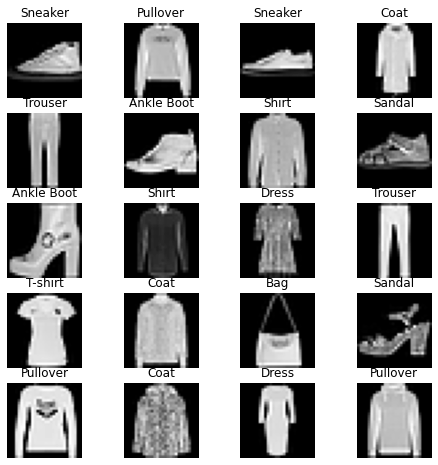

In [ ]:
fig = plt.figure(figsize=(8,8))
columns=4
rows=5
for i in range(1, columns*rows+1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')

plt.show()

In [ ]:
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN, self).__init__() # FashionDNN이라는 부모(super) 클래스를 상속받겠다는 의미
        self.fc1 = nn.Linear(in_features=784, out_features=256) # nn은 딥러닝 모델(네트워크) 구성에 필요한 모듈이 모여 있는 패키지
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128) # Linear는 단순 회귀 모델을 만들 때 사용한다.
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, input_data): # 순전파, 반드시 함수 이름이 forward여야 한다.
        x = input_data.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 활성화 함수 지정 방법
# 1. F.relu() : forward함수에서 사용
# 2. nn.ReLU() : __init__() 함수에서 정의

# 둘의 차이점
# F.relu() : torch.nn.functional.relu()
# nn.ReLU() : torch.nn.ReLU()


## 파라미터 정의 

In [ ]:
learning_rate = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


## 학습

In [ ]:
import time
from tqdm import tqdm

In [ ]:
print(time.time())

1648088535.7364118


In [ ]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in tqdm(range(num_epochs)):
    start_time = time.time()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Autograd는 자동 미분을 수행하는 파이토치의 핵심 패키지로, 자동 미분에 대한 값을 저장하기 위해
        # tape를 사용한다. 순전파 단계에서 데이프는 수행하는 모든 연산을 저장한다.
        # 그리고 역전파 단계에서 저장된 값들을 꺼내서 사용한다. 즉 Autograd는 Variable을 사용해서 역전파를 위한
        # 미분값을 자동으로 계산해 준다. 따라서 자동 미분을 계산하기 위해서는 torch.autograd 패키지 안에 있는 
        # Variable을 이용해야 동작한다.
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions==labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        end_time = time.time()
        if not (count % 500):
            print(f'\n Epoch : {epoch}, Iteration : {count}, Loss : {loss.data}, Accuracy : {accuracy}, duration(sec) : {int(end_time-start_time)}')
        

  0%|          | 0/5 [00:00<?, ?it/s]


 Epoch : 0, Iteration : 500, Loss : 0.5718381404876709, Accuracy : 83.15999603271484, duration(sec) : 14


 20%|██        | 1/5 [00:16<01:05, 16.29s/it]


 Epoch : 1, Iteration : 1000, Loss : 0.43334537744522095, Accuracy : 84.37999725341797, duration(sec) : 9


 40%|████      | 2/5 [00:30<00:44, 14.82s/it]


 Epoch : 2, Iteration : 1500, Loss : 0.37306568026542664, Accuracy : 84.77999877929688, duration(sec) : 6


 60%|██████    | 3/5 [00:43<00:28, 14.33s/it]


 Epoch : 3, Iteration : 2000, Loss : 0.33498215675354004, Accuracy : 85.37999725341797, duration(sec) : 4


 80%|████████  | 4/5 [00:57<00:14, 14.01s/it]


 Epoch : 4, Iteration : 2500, Loss : 0.2911621332168579, Accuracy : 85.98999786376953, duration(sec) : 2


100%|██████████| 5/5 [01:11<00:00, 14.27s/it]


 Epoch : 4, Iteration : 3000, Loss : 0.2929821014404297, Accuracy : 86.68999481201172, duration(sec) : 14


## 합성곱 적용

In [ ]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

# class FashionDNN(nn.Module):
#     def __init__(self):
#         super(FashionDNN, self).__init__() # FashionDNN이라는 부모(super) 클래스를 상속받겠다는 의미
#         self.fc1 = nn.Linear(in_features=784, out_features=256) # nn은 딥러닝 모델(네트워크) 구성에 필요한 모듈이 모여 있는 패키지
#         self.drop = nn.Dropout(0.25)
#         self.fc2 = nn.Linear(in_features=256, out_features=128) # Linear는 단순 회귀 모델을 만들 때 사용한다.
#         self.fc3 = nn.Linear(in_features=128, out_features=10)

#     def forward(self, input_data): # 순전파, 반드시 함수 이름이 forward여야 한다.
#         x = input_data.view(-1, 784)
#         x = F.relu(self.fc1(x))
#         x = self.drop(x)
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

## 파라미터 정의

In [ ]:
print(model.parameters())

<generator object Module.parameters at 0x7f9058a85150>


In [ ]:
learning_rate = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [ ]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in tqdm(range(num_epochs)):
    start_time = time.time()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions==labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        end_time = time.time()
        if not (count % 500):
            print(f'\n Epoch : {epoch}, Iteration : {count}, Loss : {loss.data}, Accuracy : {accuracy}, duration(sec) : {int(end_time-start_time)}')
        

  0%|          | 0/5 [00:00<?, ?it/s]


 Epoch : 0, Iteration : 500, Loss : 0.4780004024505615, Accuracy : 87.5999984741211, duration(sec) : 12


 20%|██        | 1/5 [00:15<01:01, 15.43s/it]


 Epoch : 1, Iteration : 1000, Loss : 0.3694848120212555, Accuracy : 87.50999450683594, duration(sec) : 10


 40%|████      | 2/5 [00:30<00:45, 15.24s/it]


 Epoch : 2, Iteration : 1500, Loss : 0.30928534269332886, Accuracy : 88.50999450683594, duration(sec) : 7


 60%|██████    | 3/5 [00:45<00:30, 15.20s/it]


 Epoch : 3, Iteration : 2000, Loss : 0.17089086771011353, Accuracy : 89.37999725341797, duration(sec) : 5


 80%|████████  | 4/5 [01:00<00:15, 15.20s/it]


 Epoch : 4, Iteration : 2500, Loss : 0.15551385283470154, Accuracy : 90.05999755859375, duration(sec) : 2


100%|██████████| 5/5 [01:16<00:00, 15.22s/it]


 Epoch : 4, Iteration : 3000, Loss : 0.19334203004837036, Accuracy : 91.02999877929688, duration(sec) : 15
